In [1]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from generate_data import ARData, fixed_ar_coefficients
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import os
from torchvision.transforms import transforms
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
#ZXY = Altered point
num_epochs = 20
learning_rate = 0.01
batch_size = 64
dtype = torch.long
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
device

device(type='cuda', index=0)

#Dataset structure#
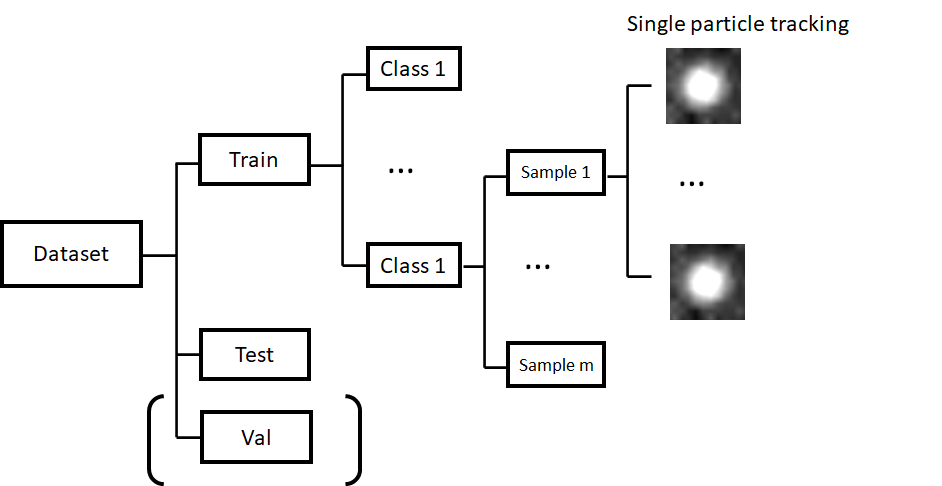

In [4]:
#required size Resnet 224, 224
#              Inception v3 N x 3 x 299 x 299
resize  = torchvision.transforms.Resize((224, 224))
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])## need mean and std
preprocessor = torchvision.transforms.Compose([ 

                                               resize,
                                               torchvision.transforms.ToTensor(), 
                                               normalize,
                                               ])
preprocessor2 = torchvision.transforms.Compose([ 
                                               #torchvision.transforms.RandomRotation(20),
                                               #torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.ToTensor(), #ToTensor transforms the image to a tensor with range [0,1]
                                               
                                               ])

In [5]:
# custom dataset
class MyDataset_3D(Dataset):
    def __init__(self, data_path, transforms=None):
        self.path = data_path
        #self.y = labels
        self.transforms = transforms
        self.classes, self.class_to_idx = self.find_classes()
        self.folders = self.folder_loader()
        print(self.class_to_idx)
    
    def find_classes(self):
        classes = os.listdir(self.path)
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    #load all video folders into the list
    def folder_loader(self):
        folders = []
        for num in self.classes:
            class_dir = os.path.join(self.path, num)
            one_class_folders = os.listdir(class_dir)
            one_class_folders = [os.path.join(class_dir, i) for i in one_class_folders]
            folders += one_class_folders
            
        return folders
             
        
    def __len__(self):
        
        return (len(self.folders))
    
    def frame_average(self, X, average = 5):
        timesteps, C, H, W = X.size()
        
        X_averaged = []
        for i in range(0, timesteps-average-1, average):
            X_averaged.append(X[i:i+average].mean(0))
        X_averaged.append(X[-average:].mean(0))
        
        return torch.stack(X_averaged, dim = 0)
            
            
        
    def read_images(self, one_folder):
        X = []
        frames = os.listdir(one_folder)
        count = 1
        for frame in frames:
            #pay attenention to convert type
            #Image.open().convert('L') 
            #print(os.path.join(one_folder, frame))
            image = Image.open(os.path.join(one_folder, frame))
#             'I' is 32-bit signed integer pixels, you can use 'I;16',
#              but in torchvision.transforms.ToTensor(), if pic.mode == 'I;16':
#              img = torch.from_numpy(np.array(pic, np.int16, copy=False))
#              np.int16 is singed 16 bit

            #ZXY
            #image = image.resize(size = (20,20))
            if self.transforms:
                image = self.transforms(image)
            else:
                image = torch.tensor(image)    

            image = image.float()

            X.append(image)
            #print(image.shape)
            count = count+1
            
          
        X = torch.stack(X, dim = 0)
        
        #normalize X over the single particle whole track
        Xmax = torch.max(X)
        Xmin = torch.min(X)
        X = (X-Xmin)/(Xmax-Xmin)
        X = (X-torch.mean(X))/torch.std(X)
        
        #X = self.frame_average(X)
        #print(X.shape)
        
        #ZXY elongate time series
#         X = torch.cat((X,torch.flip(X, [0]),X), dim = 0)
#         X = torch.cat((X,torch.flip(X, [0]),X), dim = 0)
        
#         ZXY change input dim
#         X = X.view(-1,4,10,10)
#         print(torch.mean(X[48]))

        return X
        
        
    def __getitem__(self, index):
        X = []
        
        folder = self.folders[index]
        #print(folder)
        class_name = os.path.basename(os.path.dirname(folder)) 
        #print(class_name)
        X = self.read_images(folder)

        #print(self.class_to_idx)
        y = torch.LongTensor([self.class_to_idx[class_name]])
        #print(y)

        return X, y
    
#     image = Image.open('C:\\Users\\ZXY\\Desktop\\ASU\\Lab\\CellClassfier\\dataset1\\0_5um\\ID1\\000001.tif')
#     pixels = list(image.getdata())

In [6]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset_EvU\train'
train_data = MyDataset_3D(Dataset_path, preprocessor2)

train_loader = DataLoader(train_data, batch_size, shuffle=True)

{'Ecoli': 0, 'Urine': 1}


In [45]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset_EvU_2\train'
train_data_2 = MyDataset_3D(Dataset_path, preprocessor2)

train_loader_2 = DataLoader(train_data_2, batch_size, shuffle=True)

{'Urine': 0}


In [7]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset_EvU\test'
test_data = MyDataset_3D(Dataset_path, preprocessor2)

test_loader = DataLoader(test_data, batch_size, shuffle=True)

{'Ecoli': 0, 'Urine': 1}


In [8]:
Dataset_path = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\dataset_EvU\val'
val_data = MyDataset_3D(Dataset_path, preprocessor2)

val_loader = DataLoader(val_data, batch_size, shuffle=True)

{'Ecoli': 0, 'Urine': 1}


In [9]:
for i, (X_batch, labels_batch )in enumerate(train_loader):
    print(X_batch.shape)
    print(labels_batch)
    break

torch.Size([64, 500, 1, 10, 10])
tensor([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1]])


In [10]:
# for i, (X_batch, labels_batch )in enumerate(test_loader):
#     print(X_batch.shape)
#     print(labels_batch)
#     break

In [72]:
# predict
def predict(model, loader):
    model.to(device)
    model.eval()
    with torch.no_grad():     
        
        for images, labels in loader:
            images = images.to(device,dtype=torch.float)
            labels = labels.squeeze().to(device)
            batch_rep, y_pred, embed, extra = model.forward(images)
            print(batch_rep.shape)

            try:
                rep = torch.cat((rep,batch_rep),1)
            except NameError:
                rep = batch_rep   
                
    model.train()
    return rep

In [12]:
#####################
# Build model
#####################

# Here we define our model as a class
class CNN_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(CNN_LSTM, self).__init__()
        self.input_ch = input_ch
        self.ch1, self.ch2 = 16, 32 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.k1, self.k2 = 5, 5
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes

        self.cnn1 = nn.Conv2d(self.input_ch, self.ch1, self.k1)
        self.cnn2 = nn.Conv2d(self.ch1, self.ch2, self.k2)

        self.fc1 = nn.Linear(((10-self.k1+1)-self.k2+1)**2 * self.ch2, self.cnn_embed_dim) # 10 is image size
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.cnn1(cnn_in)
        x = nn.functional.relu(x)

        x = self.cnn2(x)
        x = nn.functional.relu(x)
        
#         print(x.shape)
        x = x.view(-1, ((10-self.k1+1)-self.k2+1)**2 * self.ch2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
#         print(x.shape)
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        embed = x

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed
    
class Linear_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Linear_LSTM, self).__init__()
        self.input_ch = input_ch 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes

        self.fc1 = nn.Linear(10*10, self.cnn_embed_dim, bias = True) # 10 is image size
#         self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
#         self.fc1.weight.data.fill_(0.01)
        self.softmax = nn.Softmax()
      
    #separate operations on each channel
    def divide_inputs(self,X):
        batch_size, timesteps, C, H, W = X.size()
        x  =  X.view(batch_size*timesteps, C, H*W)
        embed = self.fc1(x[:,0,:])

        for i in range(C-1):
            embed = torch.cat((embed,self.fc1(x[:,i+1,:])), dim = 1)

        return embed             

    def forward(self, X_stacked):
        
#         print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        
#         x  =  X_stacked.view(batch_size*timesteps, C*H*W)#need to be checked
        
#         x = self.fc1(x)
#         x = nn.functional.relu(x)
        x = self.divide_inputs(X_stacked)  
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        embed = x#here view may distort the X

        lstm_out, (h_n, h_c) = self.lstm(x)# -1 is timesteps here
                                           # here view distort the X
     
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed

#this model is constructed to mimic extracting 1d time information, checked
class Linear_CNN1D(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Linear_CNN1D, self).__init__()
        self.input_ch = input_ch         
        self.ch1, self.ch2, self.ch3 = 6, 16, 26 
        self.k1, self.k2, self.k3 = 5, 5, 3


        self.embed_dim = 1 #cnn-embedded dim 

        self.N_classes = N_classes

        self.cnn1 = nn.Conv1d(self.input_ch, self.ch1, self.k1, stride=2)
        self.cnn2 = nn.Conv1d(self.ch1, self.ch2, self.k2, stride=2)
        self.cnn3 = nn.Conv1d(self.ch2, self.ch3, self.k3, stride=2)
        
        self.fc1 = nn.Linear(1*10*10, self.embed_dim) # 10 is image size
        self.fc2 = nn.Linear(26, 8)
        self.fc3 = nn.Linear(8, self.N_classes)
        
        self.fc1.weight.data.fill_(0.01)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        

        batch_size, timesteps, C, H, W = X_stacked.size()
        x  =  X_stacked.view(batch_size*timesteps, C*H*W)#need to be checked
        
        x = self.fc1(x)
        #x = nn.functional.leaky_relu(x)

        x = x.view(batch_size, 1, -1)
        emd = x

        x = nn.functional.max_pool1d(self.cnn1(x),2)
        x = nn.functional.max_pool1d(self.cnn2(x),2)
        x = nn.functional.max_pool1d(self.cnn3(x),2)

        x = x.view(-1, self.num_flat_features(x))
        x = nn.functional.relu(self.fc2(x))

        y_pred = self.fc3(x)

        y_pred = self.softmax(y_pred)

        return y_pred, emd
    
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
class CNN_ENCODER_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(CNN_ENCODER_LSTM, self).__init__()
        self.input_ch = input_ch
        self.ch1, self.ch2 = 4, 8 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.k1, self.k2 = 5, 5
        self.h_d = 8
        self.num_layers = 2
        self.N_classes = N_classes
        
        self.encoder = nn.Sequential(
            nn.Conv2d(self.input_ch, self.ch1, self.k1),
            nn.ReLU(True),
            nn.Conv2d(self.ch1, self.ch2, self.k2),
            nn.ReLU(True)
            )

        self.fc1 = nn.Linear(((10-self.k1+1)-self.k2+1)**2 * self.ch2, self.cnn_embed_dim) # 10 is image size
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.encoder(cnn_in)
        
#         print(x.shape)
        x = x.view(-1, ((10-self.k1+1)-self.k2+1)**2 * self.ch2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
#         print(x.shape)
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        embed = x

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred, embed
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(4,8,kernel_size=5),
            nn.ReLU(True))
            
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(8,4,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(4,1,kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        embed = x
        x = self.decoder(x)

        return x, embed

In [13]:
#####################
# Build model
#####################
class newresnet(torch.nn.Module):
    def __init__(self):
        super(newresnet, self).__init__()

        self.newresnet18  = torchvision.models.resnet18(pretrained = True)
        # for param in self.newresnet18.parameters():
        #     param.requires_grad = False
        # here in_feature is 512*block.expansion
        num_ftrs = self.newresnet18.fc.in_features 

        # remove the last fc layer
        # myresnet = torch.nn.Sequential(*list(myresnet.children())[:-1])
        self.newresnet18.fc = torch.nn.Identity()
        self.fc = torch.nn.Linear(num_ftrs, num_classes)
    def forward(self,x):
        x = self.newresnet18(x)
        # x = torch.flatten(x,1)
        x = self.fc(x)
        return x

class Resnet_LSTM(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(Resnet_LSTM, self).__init__()
        self.input_ch = input_ch 
        self.h_d = 16
        self.num_layers = 2
        self.N_classes = N_classes
        
        self.newresnet18  = torchvision.models.resnet18(pretrained = True)

        self.cnn_embed_dim = self.newresnet18.fc.in_features 

        self.newresnet18.fc = torch.nn.Identity()
        
        self.lstm = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def forward(self, X_stacked):
        
        #print(X_stacked.size())
        X_stacked = torch.cat((X_stacked,X_stacked,X_stacked), dim = 2)
        batch_size, timesteps, C, H, W = X_stacked.size()
        
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.newresnet18(cnn_in)

        lstm_out, (h_n, h_c) = self.lstm(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        
        y_pred = self.fc2(lstm_out[-1].view(batch_size, -1))# -1 is self.h_d here
        #y_pred = self.softmax(y_pred)

        return y_pred

In [14]:
#####################
# Build model
#####################
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_ch = 1, N_classes = 2):
        super(LSTM_Autoencoder, self).__init__()
        self.input_ch = input_ch
        self.ch1, self.ch2 = 4, 8 
        self.cnn_embed_dim = 8 #cnn-embedded dim 
        self.k1, self.k2 = 5, 5
        self.h_d = self.cnn_embed_dim # be aware of here ZXY 
        self.num_layers = 2
        self.N_classes = N_classes
        
        self.encoder = nn.Sequential(
            nn.Conv2d(self.input_ch, self.ch1, self.k1),
            nn.ReLU(True),
            nn.Conv2d(self.ch1, self.ch2, self.k2),
            nn.ReLU(True)
            )

        self.fc1 = nn.Linear(((10-self.k1+1)-self.k2+1)**2 * self.ch2, self.cnn_embed_dim) # 10 is image size
        
        self.lstm_en = nn.LSTM(self.cnn_embed_dim, self.h_d, self.num_layers)
        self.lstm_de = nn.LSTM(self.h_d, self.cnn_embed_dim, self.num_layers)
        
        self.fc2 = nn.Linear(self.h_d, self.N_classes)
        self.softmax = nn.Softmax()


    def lstm_encoder(self, X_stacked):
        
        #print(X_stacked.size())
        batch_size, timesteps, C, H, W = X_stacked.size()
        cnn_in  =  X_stacked.view(batch_size*timesteps, C, H, W)#need to be checked
        
        x = self.encoder(cnn_in)
#         print(x.shape)
        x = x.view(-1, ((10-self.k1+1)-self.k2+1)**2 * self.ch2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        cnn_embed = x
        
        x = x.view(batch_size, timesteps, self.cnn_embed_dim)
        x = x.permute(1,0,2)
        
        rep, (h_n, h_c) = self.lstm_en(x.view(-1, batch_size, self.cnn_embed_dim))# -1 is timesteps here
        extra = rep
        
#         rep[-1, :, :].unsqueeze(0)

        return rep[-1, :, :].unsqueeze(0), cnn_embed, extra

    def forward(self, X_stacked):
        
        batch_size, timesteps, C, H, W = X_stacked.size()
        rep, cnn_embed, extra = self.lstm_encoder(X_stacked)
        batch_rep = rep
        decoder_generated = []
        
        for i in range(timesteps):
            rep, (h_n, h_c) = self.lstm_en(rep)
            decoder_generated.append(rep)
            
        decoder_generated = torch.stack(decoder_generated, dim = 0)
        decoder_generated = decoder_generated.view(batch_size*timesteps,-1)
        return batch_rep, decoder_generated, cnn_embed, extra

In [15]:
# # for loading
# autoenoder = Autoencoder()# (use the class to initialize the model)
# autoenoder.to(device)
# autoenoder.eval()
# fname = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\Autoencoder\autoencoder.pt'
# autoenoder.load_state_dict(torch.load(fname), strict = False)

In [16]:
# model = CNN_LSTM()
# model = Resnet_LSTM()
# model = Linear_LSTM()
# model = Linear_CNN1D()
# model = CNN_ENCODER_LSTM()
model = LSTM_Autoencoder()
model.to(device)

LSTM_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (lstm_en): LSTM(8, 8, num_layers=2)
  (lstm_de): LSTM(8, 8, num_layers=2)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)

In [17]:
fname = r'C:\Users\ZXY\Desktop\ASU\Lab\CellClassfier\Autoencoder\autoencoder.pt'
model.load_state_dict(torch.load(fname), strict = False)

_IncompatibleKeys(missing_keys=['fc1.weight', 'fc1.bias', 'lstm_en.weight_ih_l0', 'lstm_en.weight_hh_l0', 'lstm_en.bias_ih_l0', 'lstm_en.bias_hh_l0', 'lstm_en.weight_ih_l1', 'lstm_en.weight_hh_l1', 'lstm_en.bias_ih_l1', 'lstm_en.bias_hh_l1', 'lstm_de.weight_ih_l0', 'lstm_de.weight_hh_l0', 'lstm_de.bias_ih_l0', 'lstm_de.bias_hh_l0', 'lstm_de.weight_ih_l1', 'lstm_de.weight_hh_l1', 'lstm_de.bias_ih_l1', 'lstm_de.bias_hh_l1', 'fc2.weight', 'fc2.bias'], unexpected_keys=['decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias'])

In [18]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

optimizer = torch.optim.Adam([
                              {'params':model.fc1.parameters(),'lr': learning_rate/1000},
                              {'params':model.lstm_en.parameters()},
                              {'params':model.lstm_de.parameters()},
                              {'params':model.fc2.parameters()},
                              {'params':model.encoder.parameters(), 'lr': 0},
                             ], 
                             lr = learning_rate)

In [19]:
model.encoder

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU(inplace=True)
)

In [20]:
#For updating learning rate
def update_lr(opt, divide = 2):
    for param_group in opt.param_groups:
        param_group['lr'] = param_group['lr']/divide

In [21]:
# Print model's state_dict
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

LSTM_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (lstm_en): LSTM(8, 8, num_layers=2)
  (lstm_de): LSTM(8, 8, num_layers=2)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)
Model's state_dict:
encoder.0.weight 	 torch.Size([4, 1, 5, 5])
encoder.0.bias 	 torch.Size([4])
encoder.2.weight 	 torch.Size([8, 4, 5, 5])
encoder.2.bias 	 torch.Size([8])
fc1.weight 	 torch.Size([8, 32])
fc1.bias 	 torch.Size([8])
lstm_en.weight_ih_l0 	 torch.Size([32, 8])
lstm_en.weight_hh_l0 	 torch.Size([32, 8])
lstm_en.bias_ih_l0 	 torch.Size([32])
lstm_en.bias_hh_l0 	 torch.Size([32])
lstm_en.weight_ih_l1 	 torch.Size([32, 8])
lstm_en.weight_hh_l1 	 torch.Size([32, 8])
lstm_en.bias_ih_l1 	 torch.Size([32])
lstm_en.bias_hh_l1 	 torch.Size([32])

In [22]:
for param_group in optimizer.param_groups:
    a = param_group['lr']
    print(a)

1e-05
0.01
0.01
0.01
0


In [23]:
#####################
# Train model
#####################

hist = np.zeros(num_epochs)
hist_2 = np.zeros(num_epochs)
accuracy_train = np.zeros(num_epochs)
accuracy_test = np.zeros(num_epochs)
accuracy_val = np.zeros(num_epochs)
total_step = len(train_loader)

flag = False

for epoch in range(num_epochs):
    
    for i, (X_batch, labels_batch )in enumerate(train_loader):
        #X_batch = X_batch.permute(1,0,2,3)
        #print(X_batch.shape)
#         
        X_batch = X_batch.to(device, dtype=torch.float)
        labels_batch = labels_batch.to(device)

        #forward
        batch_rep, y_pred, embed, extra = model.forward(X_batch)

        try:
            rep = torch.cat((rep,batch_rep),1)
        except NameError:
            rep = batch_rep    
            
        #loss function
        loss = loss_fn(y_pred, embed)
        #loss2 = loss_fn2(y_pred, labels_batch)
        hist[epoch] = loss.item()

        optimizer.zero_grad()
        #backward 
        loss.backward()

        #optimize
        optimizer.step()

        if (i+1)%1 == 0:
            print("Epoch [{}/{}], Step[{}/{}] Loss:{:.4f}" 
                .format(epoch+1, num_epochs, i+1, total_step, loss.item() ))
#         _,__ , accuracy_train[epoch]= predict(model, train_loader)
#         _,__ , accuracy_test[epoch]= predict(model, test_loader)
#         _,__ , accuracy_val[epoch]= predict(model, val_loader)


        if loss.item()<0:
            flag = True
            break
    if flag:
        break
        
#     if (epoch+1) > 200:   
#         if (epoch+1)%100 == 0:
#             update_lr(optimizer, 1.1)
    
      
        

Epoch [1/20], Step[1/7] Loss:0.7989
Epoch [1/20], Step[2/7] Loss:0.7934
Epoch [1/20], Step[3/7] Loss:0.8086
Epoch [1/20], Step[4/7] Loss:0.7620
Epoch [1/20], Step[5/7] Loss:0.7747
Epoch [1/20], Step[6/7] Loss:0.7652
Epoch [1/20], Step[7/7] Loss:0.7986
Epoch [2/20], Step[1/7] Loss:0.7790
Epoch [2/20], Step[2/7] Loss:0.7559
Epoch [2/20], Step[3/7] Loss:0.7455
Epoch [2/20], Step[4/7] Loss:0.7214
Epoch [2/20], Step[5/7] Loss:0.7168
Epoch [2/20], Step[6/7] Loss:0.7000
Epoch [2/20], Step[7/7] Loss:0.7076
Epoch [3/20], Step[1/7] Loss:0.6884
Epoch [3/20], Step[2/7] Loss:0.7038
Epoch [3/20], Step[3/7] Loss:0.6660
Epoch [3/20], Step[4/7] Loss:0.6680
Epoch [3/20], Step[5/7] Loss:0.6716
Epoch [3/20], Step[6/7] Loss:0.6475
Epoch [3/20], Step[7/7] Loss:0.6239
Epoch [4/20], Step[1/7] Loss:0.6304
Epoch [4/20], Step[2/7] Loss:0.6181
Epoch [4/20], Step[3/7] Loss:0.6031
Epoch [4/20], Step[4/7] Loss:0.5716
Epoch [4/20], Step[5/7] Loss:0.5724
Epoch [4/20], Step[6/7] Loss:0.5590
Epoch [4/20], Step[7/7] Loss

In [24]:
extra

tensor([[[ 4.9954e-02,  7.3550e-01,  3.1444e-01,  ...,  1.3694e-02,
           7.1305e-01,  1.2257e-04],
         [ 5.0446e-02,  7.3455e-01,  3.1260e-01,  ...,  1.3724e-02,
           7.1155e-01,  4.0616e-04],
         [ 4.5542e-02,  7.4800e-01,  3.3672e-01,  ...,  1.2694e-02,
           7.3291e-01, -3.6816e-04],
         ...,
         [ 5.0646e-02,  7.3409e-01,  3.1201e-01,  ...,  1.3785e-02,
           7.1088e-01,  3.8177e-04],
         [ 5.0106e-02,  7.3562e-01,  3.1395e-01,  ...,  1.3728e-02,
           7.1315e-01,  3.2862e-04],
         [ 5.0229e-02,  7.3493e-01,  3.1295e-01,  ...,  1.3661e-02,
           7.1209e-01,  4.4386e-04]],

        [[ 7.1924e-02,  9.4741e-01,  5.1676e-01,  ...,  6.3395e-02,
           8.6813e-01,  5.9399e-03],
         [ 7.1784e-02,  9.4730e-01,  5.1615e-01,  ...,  6.3203e-02,
           8.6786e-01,  6.2609e-03],
         [ 7.0000e-02,  9.4973e-01,  5.2405e-01,  ...,  6.2801e-02,
           8.7231e-01,  6.5550e-03],
         ...,
         [ 7.2764e-02,  9

In [25]:
rep[0]

tensor([[-0.2032,  0.2468, -0.1480,  ..., -0.0389, -0.0141,  0.1199],
        [-0.1538,  0.2531,  0.0047,  ...,  0.0296, -0.0837,  0.1646],
        [-0.1871,  0.2755, -0.0120,  ...,  0.0233, -0.0605,  0.1678],
        ...,
        [ 0.0649,  0.9972,  0.6564,  ...,  0.3442,  0.9079,  0.0492],
        [ 0.0601,  0.9978,  0.6631,  ...,  0.3423,  0.9104,  0.0462],
        [ 0.0640,  0.9971,  0.6558,  ...,  0.3462,  0.9072,  0.0511]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [26]:
# #used for Linear_LSTM to plot fc1 output
# emb = embed
# fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot(emb.cpu().detach().numpy()[0:3600], label='t')
# # plt.ylim(0.58, 0.68)


In [27]:
# #used for Linear_LSTM to plot fc1 output
# emb = embed[:,:,1]
# print(emb.shape)
# fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
# for i in range(4):
#     plt.subplot(4,1,i+1)
#     plt.plot(emb.cpu().detach().numpy()[:,i].T, label='t')
# #     plt.ylim(0.58, 0.68)

In [28]:
labels_batch.cpu().detach().numpy().T

array([[0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 0]], dtype=int64)

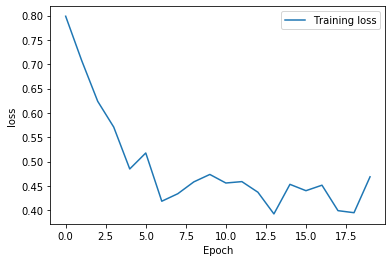

In [29]:
#####################
# Plot preds and performance
#####################
plt.plot(hist, label="Training loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()


# plt.plot(y_pred.cpu().detach().numpy(), label="Preds")
# plt.plot(y_train.cpu().detach().numpy(), label="labels")
# plt.legend()
# plt.show() 



In [30]:
# ####################
# # Plot preds and performance
# ####################
# plt.plot(accuracy_train, label="accuracy_train")
# plt.plot(accuracy_test, label="accuracy_test")
# plt.plot(accuracy_val, label="accuracy_val")
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy  %')
# plt.legend()
# plt.show()

In [31]:
# train_predicts, train_labels, accuracy = predict(model, train_loader)
# cm = metrics.confusion_matrix(train_labels, train_predicts)

# fig,ax = plot_confusion_matrix(cm, colorbar = True, show_normed = True)
# plt.show()

In [124]:
rep2 = predict(model, train_loader)

torch.Size([1, 64, 8])
torch.Size([1, 64, 8])
torch.Size([1, 64, 8])
torch.Size([1, 64, 8])
torch.Size([1, 64, 8])
torch.Size([1, 64, 8])
torch.Size([1, 46, 8])


In [125]:
rep2.shape

torch.Size([1, 430, 8])

In [126]:
# x_subset = rep[0,-430:,:]

In [127]:
x_subset = rep2.squeeze(0)

In [128]:
x_subset.shape

torch.Size([430, 8])

In [129]:
x_subset

tensor([[0.0718, 0.9991, 0.6670,  ..., 0.3104, 0.9203, 0.0138],
        [0.0697, 0.9986, 0.6633,  ..., 0.3231, 0.9165, 0.0272],
        [0.0706, 0.9992, 0.6688,  ..., 0.3098, 0.9204, 0.0130],
        ...,
        [0.0721, 0.9992, 0.6683,  ..., 0.3108, 0.9203, 0.0136],
        [0.0649, 0.9972, 0.6550,  ..., 0.3450, 0.9074, 0.0499],
        [0.0702, 0.9993, 0.6707,  ..., 0.3100, 0.9204, 0.0120]],
       device='cuda:0')

In [130]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
x_subset = x_subset.cpu().detach().numpy()

X_tsne = TSNE(n_components=2,  perplexity=12.0, random_state=123).fit_transform(x_subset)#, random_state=123

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 1.1852657794952393 seconds


In [131]:
X_tsne.shape

(430, 2)

(-54.64868139667652, 51.80697607441089, -39.98400234040031, 49.80699657257804)

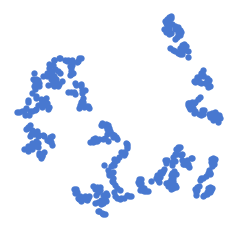

In [132]:
f = plt.figure(figsize=(4, 4))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], lw=0, s=40)
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')

In [133]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(x_subset, quantile=0.2)
clustering = MeanShift(bandwidth= bandwidth).fit(x_subset)
clustering.labels_

array([0, 2, 0, 3, 2, 2, 1, 0, 2, 4, 0, 0, 1, 1, 2, 2, 0, 2, 4, 0, 0, 0,
       4, 2, 3, 0, 0, 3, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 2, 1, 0, 2,
       0, 1, 0, 2, 0, 3, 0, 0, 1, 0, 0, 3, 0, 0, 0, 3, 0, 3, 4, 3, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 4, 3, 4, 3, 0, 0, 2, 2, 0, 2, 1, 2,
       0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 1, 0, 4, 2, 1, 0, 0, 3, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 4, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 3, 1, 3, 0,
       0, 4, 0, 0, 1, 1, 0, 0, 1, 3, 4, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0,
       1, 2, 3, 0, 4, 0, 4, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 3, 0, 0,
       2, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 4, 1, 0, 3, 0, 0,
       0, 4, 0, 2, 2, 1, 2, 0, 0, 0, 2, 4, 4, 0, 2, 2, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 3, 0, 0, 0, 2, 0,
       0, 3, 0, 1, 1, 1, 0, 2, 0, 1, 3, 4, 0, 2, 4, 0, 0, 1, 0, 4, 1, 0,
       1, 0, 0, 3, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1,
       1, 2, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 0, 2, 0,

In [134]:
bandwidth

0.009631240672836237

(<Figure size 432x432 with 1 Axes>,
 [Text(-23.975283, -0.8834007, '0'),
  Text(31.608946, 23.054443, '1'),
  Text(16.674807, -21.528713, '2'),
  Text(40.38778, -24.391584, '3'),
  Text(31.260561, -11.2925, '4')])

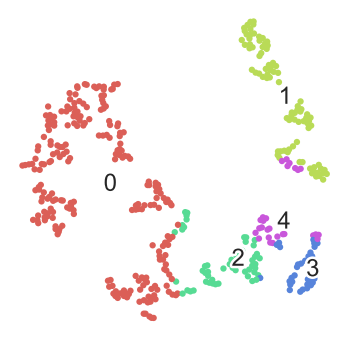

In [135]:
fashion_scatter(X_tsne, clustering.labels_)

In [136]:
# Utility function to visualize the outputs of PCA and t-SNE
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
import matplotlib.patheffects as PathEffects

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(6, 6))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts